In [28]:
import os
import json
import time
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

import datetime

In [92]:
from sklearn.model_selection import KFold
from sklearn import model_selection, preprocessing, metrics
from sklearn import model_selection

import xgboost as xgb
import lightgbm as lgb

# Import necessary modules
from sklearn_pandas import DataFrameMapper
from sklearn_pandas import CategoricalImputer

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

ImportError: No module named 'sklearn_pandas'

In [30]:
df_train = pd.read_csv('train.csv', parse_dates=['first_active_month'])
df_test = pd.read_csv('test.csv', parse_dates=['first_active_month'])

In [31]:
print(df_train.shape,df_test.shape)

(201917, 6) (123623, 5)


In [32]:
df_train.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913


Plot from https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo

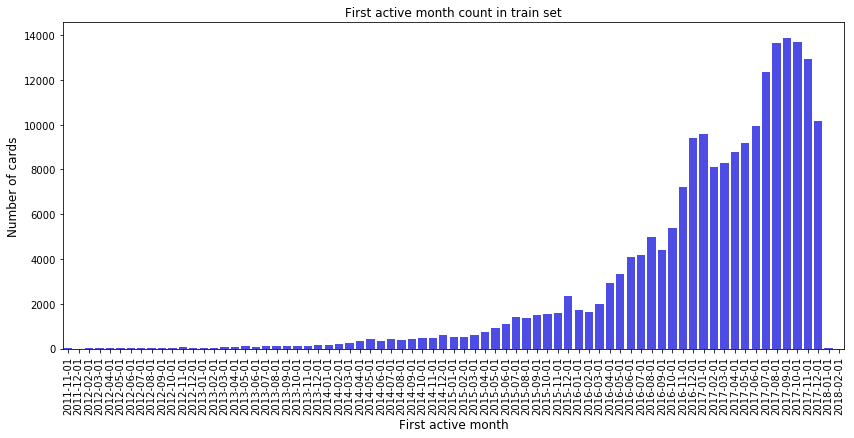

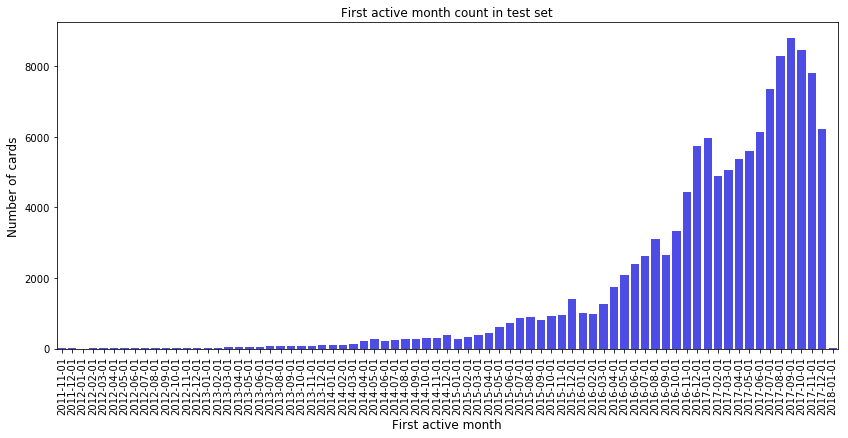

In [33]:
cnt_srs = df_train['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='b')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

cnt_srs = df_test['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='b')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in test set")
plt.show()

In [7]:
df_train.corr()

,feature_1,feature_2,feature_3,target
feature_1,1.000000,-0.130969,0.583092,-0.014251
feature_2,-0.130969,1.000000,0.060925,-0.006242
feature_3,0.583092,0.060925,1.000000,-0.008125
target,-0.014251,-0.006242,-0.008125,1.000000


### feature_1 and feature_3 are strongly correlated. The rest are weak correlations. Perhaps a feature combination??

In [34]:
df_train["month"] = df_train["first_active_month"].dt.month
df_test["month"] = df_test["first_active_month"].dt.month

df_train["year"] = df_train["first_active_month"].dt.year
df_test["year"] = df_test["first_active_month"].dt.year

df_train['elapsed_time'] = (datetime.date(2018, 2, 1) - df_train['first_active_month'].dt.date).dt.days
df_test['elapsed_time'] = (datetime.date(2018, 2, 1) - df_test['first_active_month'].dt.date).dt.days

## Note:: The last date for the first_active_month from the plots above is 2018-02-01

df_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,6,2017,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1,2017,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,8,2016,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,9,2017,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,11,2017,92


From various kernels, and intuitively, the elapsed time for which the account has been active affects the loyalty score

In [35]:
# Much easier way to add one_hot_encoding for categorical variables than my last notebook

df_train = pd.get_dummies(df_train, columns=['feature_1', 'feature_2','feature_3'])
df_test = pd.get_dummies(df_test, columns=['feature_1', 'feature_2','feature_3'])
df_train.head()

,first_active_month,card_id,target,month,year,elapsed_time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1
0,2017-06-01,C_ID_92a2005557,-0.820283,6,2017,245,0,0,0,0,1,0,1,0,0,1
1,2017-01-01,C_ID_3d0044924f,0.392913,1,2017,396,0,0,0,1,0,1,0,0,1,0
2,2016-08-01,C_ID_d639edf6cd,0.688056,8,2016,549,0,1,0,0,0,0,1,0,1,0
3,2017-09-01,C_ID_186d6a6901,0.142495,9,2017,153,0,0,0,1,0,0,0,1,1,0
4,2017-11-01,C_ID_cdbd2c0db2,-0.159749,11,2017,92,1,0,0,0,0,0,0,1,1,0


In [36]:
df_hist = pd.read_csv('historical_transactions.csv')
df_hist.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [37]:
df_hist = pd.get_dummies(df_hist, columns=['category_1','category_2','category_3','authorized_flag'])
df_hist.head()

,card_id,city_id,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_1_N,category_1_Y,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C,authorized_flag_N,authorized_flag_Y
0,C_ID_4e6213e9bc,88,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,37,1,0,1,0,0,0,0,1,0,0,0,1
1,C_ID_4e6213e9bc,88,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,16,1,0,1,0,0,0,0,1,0,0,0,1
2,C_ID_4e6213e9bc,88,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,37,1,0,1,0,0,0,0,1,0,0,0,1
3,C_ID_4e6213e9bc,88,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,34,1,0,1,0,0,0,0,1,0,0,0,1
4,C_ID_4e6213e9bc,88,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,37,1,0,1,0,0,0,0,1,0,0,0,1


### In the above, we could also not encode category_1 and authorized_flag as one-hot, and just map the variables to 0's and 1's

### The function below is a variation on a set of kernels, principally https://www.kaggle.com/peterhurford/you-re-going-to-want-more-categories-lb-3-737

In [38]:
def aggregate_transactions(df, prefix):  
    df.loc[:, 'purchase_date'] = pd.DatetimeIndex(df['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    # The above line converts pandas datetimeindex to unix time 
    # https://stackoverflow.com/questions/15203623/convert-pandas-datetimeindex-to-unix-time
    
    # The aggregate functions will be applied to each feature after grouping them by card_id
    agg_func = {
#         'authorized_flag_N': ['sum', 'mean'], -- comment this out -- 
        # does not exist in df_new -- make separate functions later
        'authorized_flag_Y': ['sum', 'mean'], 
        'category_1_N': ['mean'],
        'category_1_Y': ['mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp], # Gives range of values along an axis 
                                   #  https://docs.scipy.org/doc/numpy/reference/generated/numpy.ptp.html
        'month_lag': ['min', 'max']
    }
    
    agg_df = df.groupby(['card_id']).agg(agg_func)
    agg_df.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    df = (df.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))
    
    df = pd.merge(df, agg_df, on='card_id', how='left')
    
    return df

In [39]:
df_hist = aggregate_transactions(df_hist, prefix='hist_')

df_train = pd.merge(df_train, df_hist, on='card_id',how='left')
df_test = pd.merge(df_test, df_hist, on='card_id',how='left')

df_train.head()

,first_active_month,card_id,target,month,year,elapsed_time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,hist_transactions_count,hist_merchant_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_category_1_N_mean,hist_month_lag_min,hist_month_lag_max,hist_authorized_flag_Y_sum,hist_authorized_flag_Y_mean,hist_category_2_2.0_mean,hist_category_3_C_mean,hist_category_3_B_mean,hist_category_1_Y_mean,hist_category_2_4.0_mean,hist_category_2_3.0_mean,hist_category_3_A_mean,hist_purchase_date_ptp,hist_category_2_1.0_mean,hist_category_2_5.0_mean,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std
0,2017-06-01,C_ID_92a2005557,-0.820283,6,2017,245,0,0,0,0,1,0,1,0,0,1,260,94,-165.968739,-0.638341,2.258395,-0.739395,0.212139,1.000000,-8,0,247.0,0.950000,0.0,0.000000,0.015385,0.000000,0.000000,0.0,0.984615,20977987.0,0.988462,0.011538,4,0.015385,1,0,0.123314
1,2017-01-01,C_ID_3d0044924f,0.392913,1,2017,396,0,0,0,1,0,1,0,0,1,0,350,142,-210.006336,-0.600018,4.630299,-0.742400,0.384967,0.911429,-12,0,339.0,0.968571,0.0,0.205714,0.788571,0.088571,0.000000,0.0,0.000000,33717687.0,0.911429,0.000000,543,1.551429,10,-1,1.510777
2,2016-08-01,C_ID_d639edf6cd,0.688056,8,2016,549,0,1,0,0,0,0,1,0,1,0,43,13,-29.167391,-0.678311,-0.145847,-0.730138,0.087380,1.000000,-13,0,41.0,0.953488,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,35635623.0,0.093023,0.906977,0,0.000000,0,0,0.000000
3,2017-09-01,C_ID_186d6a6901,0.142495,9,2017,153,0,0,0,1,0,0,0,1,1,0,77,50,-49.491364,-0.642745,1.445596,-0.740897,0.261624,0.844156,-5,0,77.0,1.000000,0.0,0.090909,0.883117,0.155844,0.688312,0.0,0.000000,13375339.0,0.155844,0.000000,84,1.090909,3,-1,0.588974
4,2017-11-01,C_ID_cdbd2c0db2,-0.159749,11,2017,92,1,0,0,0,0,0,0,1,1,0,133,66,-48.687656,-0.366073,7.193041,-0.746156,1.352094,0.887218,-3,0,128.0,0.962406,0.0,0.052632,0.947368,0.112782,0.804511,0.0,0.000000,9405641.0,0.075188,0.007519,182,1.368421,12,1,1.896862


In [40]:
print(df_train.shape, df_test.shape)

(201917, 43) (123623, 42)


In [41]:
df_new = pd.read_csv('new_merchant_transactions.csv')
df_new.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [42]:
df_new = pd.get_dummies(df_new, columns=['category_1','category_2','category_3','authorized_flag'])
df_new.head()

,card_id,city_id,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_1_N,category_1_Y,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C,authorized_flag_Y
0,C_ID_415bb3a509,107,1,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,9,19,1,0,1,0,0,0,0,0,1,0,1
1,C_ID_415bb3a509,140,1,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,9,19,1,0,1,0,0,0,0,0,1,0,1
2,C_ID_415bb3a509,330,1,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,9,14,1,0,1,0,0,0,0,0,1,0,1
3,C_ID_415bb3a509,-1,1,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,-1,8,0,1,0,0,0,0,0,0,1,0,1
4,C_ID_ef55cf8d4b,-1,1,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,-1,29,0,1,0,0,0,0,0,0,1,0,1


In [43]:
df_new = aggregate_transactions(df_new, prefix='new_')

df_train = pd.merge(df_train, df_new, on='card_id',how='left')
df_test = pd.merge(df_test, df_new, on='card_id',how='left')

df_train.head()

,first_active_month,card_id,target,month,year,elapsed_time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,hist_transactions_count,hist_merchant_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_category_1_N_mean,hist_month_lag_min,hist_month_lag_max,hist_authorized_flag_Y_sum,hist_authorized_flag_Y_mean,hist_category_2_2.0_mean,hist_category_3_C_mean,hist_category_3_B_mean,hist_category_1_Y_mean,hist_category_2_4.0_mean,hist_category_2_3.0_mean,hist_category_3_A_mean,hist_purchase_date_ptp,hist_category_2_1.0_mean,hist_category_2_5.0_mean,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,new_transactions_count,new_merchant_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_category_1_N_mean,new_month_lag_min,new_month_lag_max,new_authorized_flag_Y_sum,new_authorized_flag_Y_mean,new_category_2_2.0_mean,new_category_3_C_mean,new_category_3_B_mean,new_category_1_Y_mean,new_category_2_4.0_mean,new_category_2_3.0_mean,new_category_3_A_mean,new_purchase_date_ptp,new_category_2_1.0_mean,new_category_2_5.0_mean,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std
0,2017-06-01,C_ID_92a2005557,-0.820283,6,2017,245,0,0,0,0,1,0,1,0,0,1,260,94,-165.968739,-0.638341,2.258395,-0.739395,0.212139,1.000000,-8,0,247.0,0.950000,0.0,0.000000,0.015385,0.000000,0.000000,0.0,0.984615,20977987.0,0.988462,0.011538,4,0.015385,1,0,0.123314,23.0,23.0,-13.244202,-0.575835,-0.296112,-0.724368,0.135812,1.000000,1.0,2.0,23.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,4742309.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
1,2017-01-01,C_ID_3d0044924f,0.392913,1,2017,396,0,0,0,1,0,1,0,0,1,0,350,142,-210.006336,-0.600018,4.630299,-0.742400,0.384967,0.911429,-12,0,339.0,0.968571,0.0,0.205714,0.788571,0.088571,0.000000,0.0,0.000000,33717687.0,0.911429,0.000000,543,1.551429,10,-1,1.510777,6.0,6.0,-4.355735,-0.725956,-0.701858,-0.739410,0.014326,1.000000,1.0,2.0,6.0,1.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,4887632.0,1.000000,0.0,6.0,1.000000,1.0,1.0,0.000000
2,2016-08-01,C_ID_d639edf6cd,0.688056,8,2016,549,0,1,0,0,0,0,1,0,1,0,43,13,-29.167391,-0.678311,-0.145847,-0.730138,0.087380,1.000000,-13,0,41.0,0.953488,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,35635623.0,0.093023,0.906977,0,0.000000,0,0,0.000000,1.0,1.0,-0.700326,-0.700326,-0.700326,-0.700326,NaN,1.000000,2.0,2.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,1.0,0.0,0.000000,0.0,0.0,NaN
3,2017-09-01,C_ID_186d6a6901,0.142495,9,2017,153,0,0,0,1,0,0,0,1,1,0,77,50,-49.491364,-0.642745,1.445596,-0.740897,0.261624,0.844156,-5,0,77.0,1.000000,0.0,0.090909,0.883117,0.155844,0.688312,0.0,0.000000,13375339.0,0.155844,0.000000,84,1.090909,3,-1,0.588974,7.0,7.0,-4.654372,-0.664910,-0.566740,-0.734135,0.065882,0.857143,1.0,2.0,7.0,1.0,0.0,0.000000,0.857143,0.142857,0.857143,0.000000,0.0,3625505.0,0.000000,0.0,5.0,0.714286,1.0,-1.0,0.755929
4,2017-11-01,C_ID_cdbd2c0db2,-0.159749,11,2017,92,1,0,0,0,0,0,0,1,1,0,133,66,-48.687656,-0.366073,7.193041,-0.746156,1.352094,0.887218,-3,0,128.0,0.962406,0.0,0.052632,0.947368,0.112782,0.804511,0.0,0.000000,9405641.0,0.075188,0.007519,182,1.368421,12,1,1.896862,36.0,36.0,-19.926237,-0.553507,0.450886,-0.739395,0.223821,0.944444,1.0,2.0,36.0,1.0,0.0,0.027778,0.944444,0.055556,0.694444,0.194444,0.0,4949682.0,0.055556,0.0,35.0,0.972222,2.0,-1.0,0.376913


Depending on your version of pandas isnull = isna. 
* "Is you compare the 0.20 documentation for "Working with missing data" with that of 0.22, you can see that the former uses isnull, whereas the latter uses isna."

In [44]:
df_train.isnull().sum() # We should deal with the nans later


first_active_month                 0
card_id                            0
target                             0
month                              0
year                               0
elapsed_time                       0
feature_1_1                        0
feature_1_2                        0
feature_1_3                        0
feature_1_4                        0
feature_1_5                        0
feature_2_1                        0
feature_2_2                        0
feature_2_3                        0
feature_3_0                        0
feature_3_1                        0
hist_transactions_count            0
hist_merchant_id_nunique           0
hist_purchase_amount_sum           0
hist_purchase_amount_mean          0
hist_purchase_amount_max           0
hist_purchase_amount_min           0
hist_purchase_amount_std           0
hist_category_1_N_mean             0
hist_month_lag_min                 0
hist_month_lag_max                 0
hist_authorized_flag_Y_sum         0
h

In [45]:
print(df_train.shape,df_test.shape)

(201917, 70) (123623, 69)


### lgb training params are a bit different from what we saw before. Refer https://www.kaggle.com/peterhurford/you-re-going-to-want-more-categories-lb-3-737.  This needs to be understood better. 

In [46]:
target = df_train['target']
cols_to_drop = ['card_id', 'first_active_month', 'target']
use_cols = [c for c in df_train.columns if c not in cols_to_drop]
features = list(df_train[use_cols].columns)

df_train[features].head()

,month,year,elapsed_time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,hist_transactions_count,hist_merchant_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_category_1_N_mean,hist_month_lag_min,hist_month_lag_max,hist_authorized_flag_Y_sum,hist_authorized_flag_Y_mean,hist_category_2_2.0_mean,hist_category_3_C_mean,hist_category_3_B_mean,hist_category_1_Y_mean,hist_category_2_4.0_mean,hist_category_2_3.0_mean,hist_category_3_A_mean,hist_purchase_date_ptp,hist_category_2_1.0_mean,hist_category_2_5.0_mean,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,new_transactions_count,new_merchant_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_category_1_N_mean,new_month_lag_min,new_month_lag_max,new_authorized_flag_Y_sum,new_authorized_flag_Y_mean,new_category_2_2.0_mean,new_category_3_C_mean,new_category_3_B_mean,new_category_1_Y_mean,new_category_2_4.0_mean,new_category_2_3.0_mean,new_category_3_A_mean,new_purchase_date_ptp,new_category_2_1.0_mean,new_category_2_5.0_mean,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std
0,6,2017,245,0,0,0,0,1,0,1,0,0,1,260,94,-165.968739,-0.638341,2.258395,-0.739395,0.212139,1.000000,-8,0,247.0,0.950000,0.0,0.000000,0.015385,0.000000,0.000000,0.0,0.984615,20977987.0,0.988462,0.011538,4,0.015385,1,0,0.123314,23.0,23.0,-13.244202,-0.575835,-0.296112,-0.724368,0.135812,1.000000,1.0,2.0,23.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,4742309.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
1,1,2017,396,0,0,0,1,0,1,0,0,1,0,350,142,-210.006336,-0.600018,4.630299,-0.742400,0.384967,0.911429,-12,0,339.0,0.968571,0.0,0.205714,0.788571,0.088571,0.000000,0.0,0.000000,33717687.0,0.911429,0.000000,543,1.551429,10,-1,1.510777,6.0,6.0,-4.355735,-0.725956,-0.701858,-0.739410,0.014326,1.000000,1.0,2.0,6.0,1.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,4887632.0,1.000000,0.0,6.0,1.000000,1.0,1.0,0.000000
2,8,2016,549,0,1,0,0,0,0,1,0,1,0,43,13,-29.167391,-0.678311,-0.145847,-0.730138,0.087380,1.000000,-13,0,41.0,0.953488,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,35635623.0,0.093023,0.906977,0,0.000000,0,0,0.000000,1.0,1.0,-0.700326,-0.700326,-0.700326,-0.700326,NaN,1.000000,2.0,2.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,1.0,0.0,0.000000,0.0,0.0,NaN
3,9,2017,153,0,0,0,1,0,0,0,1,1,0,77,50,-49.491364,-0.642745,1.445596,-0.740897,0.261624,0.844156,-5,0,77.0,1.000000,0.0,0.090909,0.883117,0.155844,0.688312,0.0,0.000000,13375339.0,0.155844,0.000000,84,1.090909,3,-1,0.588974,7.0,7.0,-4.654372,-0.664910,-0.566740,-0.734135,0.065882,0.857143,1.0,2.0,7.0,1.0,0.0,0.000000,0.857143,0.142857,0.857143,0.000000,0.0,3625505.0,0.000000,0.0,5.0,0.714286,1.0,-1.0,0.755929
4,11,2017,92,1,0,0,0,0,0,0,1,1,0,133,66,-48.687656,-0.366073,7.193041,-0.746156,1.352094,0.887218,-3,0,128.0,0.962406,0.0,0.052632,0.947368,0.112782,0.804511,0.0,0.000000,9405641.0,0.075188,0.007519,182,1.368421,12,1,1.896862,36.0,36.0,-19.926237,-0.553507,0.450886,-0.739395,0.223821,0.944444,1.0,2.0,36.0,1.0,0.0,0.027778,0.944444,0.055556,0.694444,0.194444,0.0,4949682.0,0.055556,0.0,35.0,0.972222,2.0,-1.0,0.376913


In [88]:
#Slopy reconstructing of the categorical variables

feature_1_col = ['feature_1_1', 'feature_1_2', 'feature_1_3', 'feature_1_4', 'feature_1_5']
feature_2_col = ['feature_2_1', 'feature_2_2', 'feature_2_3']
feature_3_col = ['feature_3_0', 'feature_3_1']

df_cat_cols_feat1 = df_train[feature_1_col]
df_cat_cols_feat2 = df_train[feature_2_col]
df_cat_cols_feat3 = df_train[feature_3_col]

feature_1 = pd.DataFrame([x for x in np.where(df_cat_cols_feat1 ==1, df_cat_cols_feat1.columns,'').flatten().tolist() if len(x) >0],columns= (["feature_1"]) )
feature_2 = pd.DataFrame([x for x in np.where(df_cat_cols_feat2 ==1, df_cat_cols_feat2.columns,'').flatten().tolist() if len(x) >0],columns= (["feature_2"]) )
feature_3 = pd.DataFrame([x for x in np.where(df_cat_cols_feat3 ==1, df_cat_cols_feat3.columns,'').flatten().tolist() if len(x) >0],columns= (["feature_3"]) )

dummie_cols_to_drop = ['feature_1_1', 'feature_1_2', 'feature_1_3', 'feature_1_4', 'feature_1_5',
                       'feature_2_1', 'feature_2_2', 'feature_2_3', 'feature_3_0', 'feature_3_1']

use_cols_2 = [c for c in df_train.columns if c not in dummie_cols_to_drop]
features_2 = list(df_train[use_cols_2].columns)

df_train[features].head()
df_train['feature_1'] = feature_1
df_train['feature_2'] = feature_2
df_train['feature_3'] = feature_3
df_train.head()

df_train['feature_1'] = df_train['feature_1'].astype(str).str[10:11].astype(np.int64)
df_train['feature_2'] = df_train['feature_2'].astype(str).str[10:11].astype(np.int64)
df_train['feature_3'] = df_train['feature_3'].astype(str).str[10:11].astype(np.int64)

df_train['feature_1'] = pd.Categorical(df_train['feature_1'], categories=["1","2","3","4","5"], ordered=False)
df_train['feature_2'] = pd.Categorical(df_train['feature_2'], categories=["1","2","3"], ordered=False)
df_train['feature_3'] = pd.Categorical(df_train['feature_3'], categories=["0","1"], ordered=False)

df_train[features_2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Data columns (total 63 columns):
first_active_month             201917 non-null datetime64[ns]
card_id                        201917 non-null object
target                         201917 non-null float64
month                          201917 non-null int64
year                           201917 non-null int64
elapsed_time                   201917 non-null int64
hist_transactions_count        201917 non-null int64
hist_merchant_id_nunique       201917 non-null int64
hist_purchase_amount_sum       201917 non-null float64
hist_purchase_amount_mean      201917 non-null float64
hist_purchase_amount_max       201917 non-null float64
hist_purchase_amount_min       201917 non-null float64
hist_purchase_amount_std       201917 non-null float64
hist_category_1_N_mean         201917 non-null float64
hist_month_lag_min             201917 non-null int64
hist_month_lag_max             201917 non-null int64
hist_authorized_f

In [91]:
X = df_train[features_2] 
# Create a boolean mask for categorical columns
categorical_feature_mask = X.dtypes == object

# Get list of categorical column names
categorical_columns = X.columns[categorical_feature_mask].tolist()

# Get list of non-categorical column names
non_categorical_columns = X.columns[~categorical_feature_mask].tolist()

# Apply numeric imputer
numeric_imputation_mapper = DataFrameMapper(
                                            [([numeric_feature], Imputer(strategy="median")) for numeric_feature in non_categorical_columns],
                                            input_df=True,
                                            df_out=True
                                           )

# Apply categorical imputer
categorical_imputation_mapper = DataFrameMapper(
                                                [(category_feature, CategoricalImputer()) for category_feature in categorical_columns],
                                                input_df=True,
                                                df_out=True
                                               )

# Import FeatureUnion
from sklearn.pipeline import FeatureUnion

# Combine the numeric and categorical transformations
numeric_categorical_union = FeatureUnion([
                                          ("num_mapper", numeric_imputation_mapper),
                                          ("cat_mapper", categorical_imputation_mapper)
                                         ])


#from https://webcache.googleusercontent.com/search?q=cache:MBRfedWnFXMJ:www.pythonexample.com/search/ackermann-function-in-matlab/5+&cd=13&hl=en&ct=clnk&gl=us
class Dictifier(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if type(X) == pd.core.frame.DataFrame:
            return X.to_dict("records")
        else:
            return pd.DataFrame(X).to_dict("records")

    def fit_transform(self, X, y=None, **fit_params):
        """Fit to data, then transform it.

        Fits transformer to X and y with optional parameters fit_params
        and returns a transformed version of X.

        Parameters
        ----------
        X : numpy array of shape [n_samples, n_features]
            Training set.

        y : numpy array of shape [n_samples]
            Target values.

        Returns
        -------
        X_new : numpy array of shape [n_samples, n_features_new]
            Transformed array.

        """
        # non-optimized default implementation; override when a better
        # method is possible for a given clustering algorithm
        if y is None:
            # fit method of arity 1 (unsupervised transformation)
            return self.fit(X, **fit_params).transform(X)
        else:
            # fit method of arity 2 (supervised transformation)
            return self.fit(X, y, **fit_params).transform(X)

    def fit(self, X, y=None):
        return self

    def get_params(self, deep=True):
        """Get parameters for this estimator.

        Parameters
        ----------
        deep : boolean, optional
            If True, will return the parameters for this estimator and
            contained subobjects that are estimators.

        Returns
        -------
        params : mapping of string to any
            Parameter names mapped to their values.
        """
        out = dict()
        for key in self._get_param_names():
            # We need deprecation warnings to always be on in order to
            # catch deprecated param values.
            # This is set in utils/__init__.py but it gets overwritten
            # when running under python3 somehow.
            warnings.simplefilter("always", DeprecationWarning)
            try:
                with warnings.catch_warnings(record=True) as w:
                    value = getattr(self, key, None)
                if len(w) and w[0].category == DeprecationWarning:
                    # if the parameter is deprecated, don't show it
                    continue
            finally:
                warnings.filters.pop(0)

            # XXX: should we rather test if instance of estimator?
            if deep and hasattr(value, 'get_params'):
                deep_items = value.get_params().items()
                out.update((key + '__' + k, val) for k, val in deep_items)
            out[key] = value
        return out

    def set_params(self, **params):
        """Set the parameters of this estimator.

        The method works on simple estimators as well as on nested objects
        (such as pipelines). The latter have parameters of the form
        ``<component>__<parameter>`` so that it's possible to update each
        component of a nested object.

        Returns
        -------
        self
        """
        if not params:
            # Simple optimization to gain speed (inspect is slow)
            return self
        valid_params = self.get_params(deep=True)

        nested_params = defaultdict(dict)  # grouped by prefix
        for key, value in params.items():
            key, delim, sub_key = key.partition('__')
            if key not in valid_params:
                raise ValueError('Invalid parameter %s for estimator %s. '
                                 'Check the list of available parameters '
                                 'with `estimator.get_params().keys()`.' %
                                 (key, self))

            if delim:
                nested_params[key][sub_key] = value
            else:
                setattr(self, key, value)

        for key, sub_params in nested_params.items():
            valid_params[key].set_params(**sub_params)

        return self

    
# Create full pipeline
pipeline = Pipeline([
                     ("featureunion", numeric_categorical_union),
                     ("dictifier", Dictifier()),
                     ("vectorizer", DictVectorizer(sort=False)),
                     ("clf", xgb.XGBRegressor(max_depth=3, objective="reg:linear"))
                    ])

# Perform cross-validation
cross_val_scores = cross_val_score(pipeline, X.to_dict("records"), target, scoring="neg_mean_squared_error", cv=10)

# Print avg. AUC
print("10-fold RMSE: ", np.mean(np.sqrt(np.abs(cross_val_scores))))

NameError: name 'DataFrameMapper' is not defined

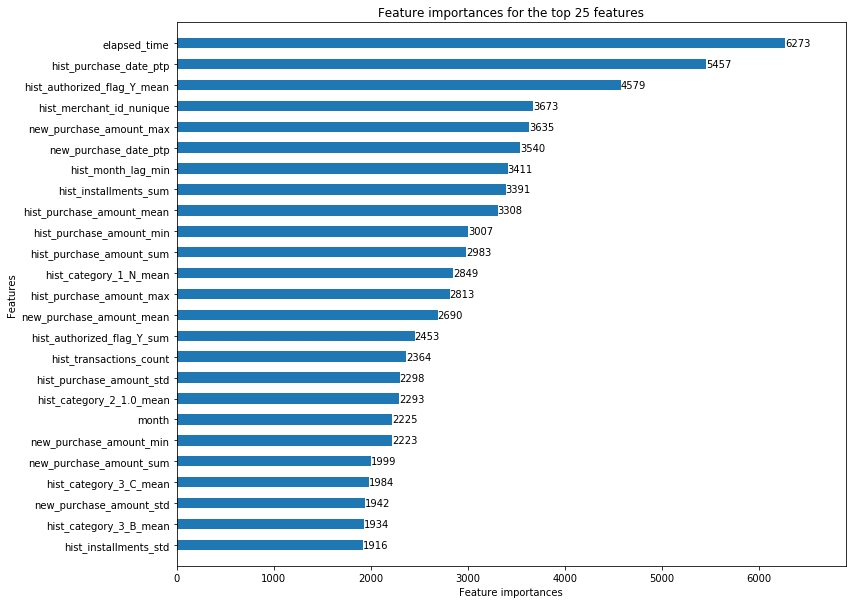

In [31]:
df_submission = pd.DataFrame({"card_id": df_test["card_id"].values})
df_submission["target"] = predictions
df_submission.to_csv("mds_einstein_sub3.csv", index=False)

## LB score of 3.737 (which is pretty good right now)
### Future outlook::
#### Use merchants.csv
#### Work on combination of features, polynomial features
#### Work on reducing overfitting by feature selection
#### Try XGBoost and Catboost
#### Try and handle the 2207 training set entries with a target < -30

## XGBoost 

In [39]:
# Import necessary modules
from sklearn_pandas import DataFrameMapper
from sklearn_pandas import CategoricalImputer


   test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0        3.877637       0.020844         3.875757        0.008031
1        3.835069       0.023296         3.831083        0.005667
2        3.811030       0.020448         3.804732        0.007449
3        3.795322       0.020045         3.786737        0.007001
4        3.775101       0.019304         3.764455        0.006296
5        3.768829       0.017788         3.755577        0.005832
6        3.763340       0.019073         3.747619        0.005447
7        3.760662       0.018811         3.742556        0.005210
8        3.755113       0.015694         3.736245        0.007004
9        3.753412       0.014953         3.730618        0.005868


AttributeError: 'DMatrix' object has no attribute 'info'